<font color=#16A085>
    
# Python Analysis of the Dynamic FRET example data
Extract E and S information and make pretty plots.

</font>

Written by: Nadia M. Huisjes and Karl E. Duderstadt

In [70]:
# File paths and names
file_path_fiji = '/Applications/Fiji-mars.app'  #Path to your Fiji application
saved_archive_name = '/Users/karlduderstadt4/git/mars-tutorials/Example_workflows/FRET/no_acceptor_excitation/holliday_junction_merged_no_aex_corrections.yama' #Name of your saved archive

In [71]:
# Import packages
import imagej
import jpype
import jpype.imports

# Set the path to the local Fiji application if it does not exist yet
try:
    ij
except NameError:
    ij = imagej.init(file_path_fiji) 
    
# Import the other packages
import scyjava as sc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
from scyjava import jimport
File = jimport("java.io.File")
from de.mpg.biochem.mars.molecule import SingleMoleculeArchive
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

plt.rcParams.update({'font.size': 9})

# Set up the connection to the archive
yamaFile = File(saved_archive_name) 
archive = SingleMoleculeArchive(yamaFile)

#### Define utility functions

In [72]:
def create_df(mol_tags):
    '''Create a df from all molecules in the archive that have all tags in the list provided'''
    #Create a map to all molecules in the archive
    molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
    
    rowsList = []
    for molecule in molecules:
        if not False in [molecule.hasTag(mol_tag) for mol_tag in mol_tags]:
            marsTable = archive.get(molecule.getUID()).getTable()
            for row in range(marsTable.getRowCount()):
                if math.isnan(marsTable.getValue('iiEapp', row)):
                    break
                rowDict = {}
                rowDict['iiEapp'] = marsTable.getValue('iiEapp', row)
                rowDict['E'] = marsTable.getValue('E', row)
                rowsList.append(rowDict)
                
    return pd.DataFrame(rowsList)

In [73]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def twoGauss(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return A1*np.exp(-(x-mu1)**2/2/sigma1**2)+A2*np.exp(-(x-mu2)**2/2/sigma2**2)

def exponentialDecay(x, a, b):
    return a * np.exp(-b * x)

In [74]:
def fit_two_state_E(df, fit_col, bins, mu1, sigma1, A1, mu2, sigma2, A2, show_model):
    ''''''
    y, bin_edges = np.histogram(df[fit_col], bins, range=(0, 1))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    expected=(mu1, sigma1, A1, mu2, sigma2, A2)
    params,cov=curve_fit(twoGauss,x,y,expected)
    
    if (show_model == True):
        plot(x,twoGauss(x,*params),color='red',lw=3,label='model')
        legend()
    
    if (show_model == False):
        plt.close()
    
    #print('The fitted peak center lies at E =',params[0],'\n','Sigma:',params[1]) #prints the fit parameters and errors that were found
    return (params[0], params[1], params[2], params[3], params[4], params[5])

#### Import the E and S data from the archive

In [75]:
df_FRET = create_df(["FRET", "Accepted"])
df_DO = create_df(["DO", "Accepted"])

### E and S before corrections

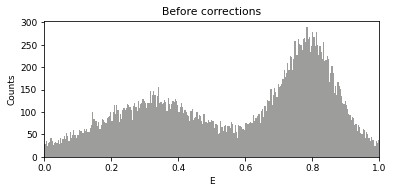

In [76]:
fig, axes = plt.subplots(1,1)

axes.hist(df_FRET['iiEapp'],bins=280,color='#9D9D9C',range=(0, 1))
axes.set_xlim(0,1)
axes.set_ylabel("Counts")
axes.set_xlabel("E")
fig.set_size_inches(6, 2.5)

plt.title("Before corrections")
plt.show()

### E and S after all corrections

0.1067326625661516 0.09114861720336041 215.9328342846032 0.5385183421540555 0.14527667923029444 170.02445012190853


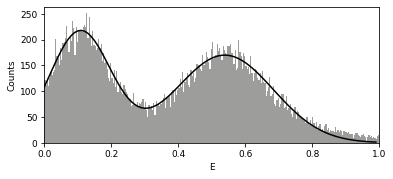

In [77]:
E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2 = fit_two_state_E(df_FRET, 'E', 280, 0.2, 0.1, 280, 0.8, 0.1, 280, False)
x_list = list(np.arange(0,1,0.01))
y_list_E = twoGauss(x_list, E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2)
print(E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2)

plt.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(1,1)

axes.hist(df_FRET['E'],bins=280,color='#9D9D9C',range=(0, 1))
axes.plot(x_list,y_list_E,color='black')
axes.set_xlim(0,1)
axes.set_ylabel("Counts")
axes.set_xlabel("E")
fig.set_size_inches(6, 2.5)

plt.savefig("/Users/karlduderstadt4/Desktop/Final_E_chart.png",dpi=300)
plt.show()

y0 = 1013.74872
t = 0.37191


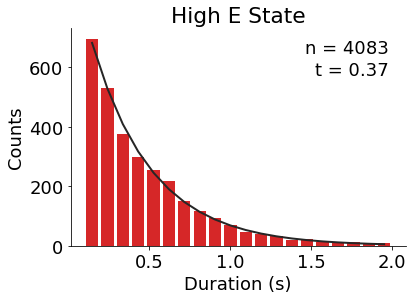

In [78]:
high_E_durations = []
molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
for molecule in molecules:
    if molecule.hasTag('FRET') and molecule.hasTag('Accepted'):
        segmentsTable = molecule.getSegmentsTable('532_Green_Time_(s)','E')
        for row in range(segmentsTable.getRowCount()):
            if segmentsTable.getValue("A", row) > 0.4:
                state = {}
                state['metaUID'] = molecule.getMetadataUID()
                state['value'] = segmentsTable.getValue("X2", row) - segmentsTable.getValue("X1", row)
                high_E_durations.append(state)
                                
high_E_durations_df = pd.DataFrame(high_E_durations)
    
y, bin_edges = np.histogram(high_E_durations_df['value'], bins=20, range=(0.1, 2))
x = (bin_edges[:-1] + bin_edges[1:]) / 2

popt, _ = curve_fit(exponentialDecay, x, y)
a, b = popt
print('y0 = %.5f\nt = %.5f' % (a, 1/b))

width = 0.8 * (x[1] - x[0])

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1,1)
#axes.plot(x, y, lw=3)
axes.bar(x, y, align='center', color='#d62728', width=width)
axes.text(.95*axes.get_xlim()[-1], .95*axes.get_ylim()[-1], "n = "+str(high_E_durations_df['value'].size),
horizontalalignment='right',verticalalignment='top')
axes.text(.95*axes.get_xlim()[-1], .85*axes.get_ylim()[-1], f"t = {np.round(1/b,2)}",
horizontalalignment='right',verticalalignment='top')

y_line = exponentialDecay(x, a, b)
# create a line plot for the mapping function
axes.plot(x, y_line, '-', color='.15', lw=2)

axes.set_title("High E State")
axes.set_xlabel("Duration (s)")
axes.set_ylabel("Counts")
axes.tick_params(axis='x', labelsize=18)
axes.tick_params(axis='y', labelsize=18)
sns.despine()

plt.savefig("/Users/karlduderstadt4/Desktop/High_FRET_chart.png",dpi=300,bbox_inches='tight')

In [79]:
taoList = []
metaUIDs = high_E_durations_df['metaUID'].unique()
for metaUID in metaUIDs:
    y, bin_edges = np.histogram(high_E_durations_df[high_E_durations_df['metaUID'].eq(metaUID)]['value'], bins=20, range=(0.1, 2))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    popt, _ = curve_fit(exponentialDecay, x, y)
    a, b = popt
    taoList.append(1/b)
    
np.std(taoList)

0.040670218246241834

y0 = 1223.25076
t1/2 = 0.30664


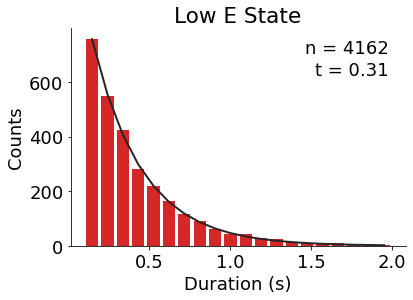

In [80]:
low_E_durations = []
molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
for molecule in molecules:
    if molecule.hasTag('FRET') and molecule.hasTag('Accepted'):
        segmentsTable = molecule.getSegmentsTable('532_Green_Time_(s)','E')
        for row in range(segmentsTable.getRowCount()):
            if segmentsTable.getValue("A", row) < 0.4:
                state = {}
                state['metaUID'] = molecule.getMetadataUID()
                state['value'] = segmentsTable.getValue("X2", row) - segmentsTable.getValue("X1", row)
                low_E_durations.append(state)
                                
low_E_durations_df = pd.DataFrame(low_E_durations)
    
y, bin_edges = np.histogram(low_E_durations_df['value'], bins=20, range=(0.1, 2))
x = (bin_edges[:-1] + bin_edges[1:]) / 2

popt, _ = curve_fit(exponentialDecay, x, y)
a, b = popt
print('y0 = %.5f\nt1/2 = %.5f' % (a, 1/b))

width = 0.8 * (x[1] - x[0])

fig, axes = plt.subplots(1,1)
axes.bar(x, y, align='center', color='#d62728', width=width)
axes.text(.95*axes.get_xlim()[-1], .95*axes.get_ylim()[-1], "n = "+str(low_E_durations_df['value'].size),
horizontalalignment='right',verticalalignment='top')
axes.text(.95*axes.get_xlim()[-1], .85*axes.get_ylim()[-1], f"t = {np.round(1/b,2)}",
horizontalalignment='right',verticalalignment='top')

y_line = exponentialDecay(x, a, b)
# create a line plot for the mapping function
axes.plot(x, y_line, '-', color='.15', lw=2)

axes.set_title("Low E State")
axes.set_xlabel("Duration (s)")
axes.set_ylabel("Counts")
axes.tick_params(axis='x', labelsize=18)
axes.tick_params(axis='y', labelsize=18)
sns.despine()

plt.savefig("/Users/karlduderstadt4/Desktop/Low_FRET_chart.png",dpi=300,bbox_inches='tight')

In [81]:
taoList = []
metaUIDs = low_E_durations_df['metaUID'].unique()
for metaUID in metaUIDs:
    y, bin_edges = np.histogram(low_E_durations_df[low_E_durations_df['metaUID'].eq(metaUID)]['value'], bins=20, range=(0.1, 2))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    popt, _ = curve_fit(exponentialDecay, x, y)
    a, b = popt
    taoList.append(1/b)
    
np.std(taoList)

0.022123422157240374

In [82]:
example_molecules = ['6YWZbr6k44UHdj9uHWHnDS', '73jKvqXmCn9Pd7wtcicXkG','aXEaurcW7KYh8H41h84aFF', 
                     'bjLEGrWXkfiWHZckHCkRiY', 'cJf5W6DNSUbAhJGb17J3Xz','dJqGcJ11agGTkAiKQPmiSV', 
                     'fPYPevZkM6giij2S2jAm8X', 'gBZdX7V9dj78Fo6Yc1am1t','guKLc61amP4qq3dqi8VuVw', 
                     'uGK2y7rgkK6joBbgnveZHn']

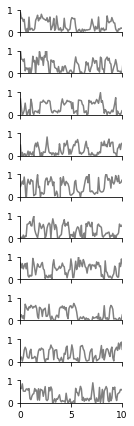

In [83]:
# HJ switching examples
rows = 10
cols = 1

plt.rcParams.update({'font.size': 9})

fig,axes=plt.subplots(rows,cols,figsize=(2,6),sharex=True, sharey=True)

for i,uid in enumerate(example_molecules):
    table = sc._table_to_pandas(archive.get(uid).getTable())
    sns.lineplot(x='532_Green_Time_(s)', y='E',data=table, ax=axes[i],color='gray')
        
for ax in axes:
    ax.set_xlabel(None)
    ax.set_ylabel(None)

plt.xlim(0,10)
plt.ylim([0,1])
sns.despine()

fig.tight_layout()

plt.savefig("/Users/karlduderstadt4/Desktop/example_molecules.svg",transparent=True)